# Purpose of the Notebook

# Problem Statement

# Module Import

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import datetime
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

#to speed up pandas operands
from pandarallel import pandarallel

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import GlobalAveragePooling1D, Flatten, Conv1D
from keras.layers import MaxPooling1D, GlobalMaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers

import keras.utils as ku 


from project5_utils import my_print
from project5_utils import my_wait

from MyMovieReview import MovieReview
from MyMovieReview import MovieReviewGenerator

from mymovie import Movie

In [2]:
%matplotlib inline 

In [3]:
LOG_FILE = open("../Data/notebook.log","w")
DEBUG = 1

In [53]:
#Setting these for now will adjust them
VOCAB_SIZE = 19000
EMBEDDING_DIM = 64
MAX_LENGTH = 1000
TRUC_TYPE = "post"
PAD_TYPE = "post"
#Out of Value Token -- or token to indicate a 
OOV_TOK = "<OOV>"

TRAIN_SET_PERCENT =  90.0
EPOCHS = 100
RANDOM_STATE = 42

BATCH_SIZE = 96

# Data Processing
Get reviews from PKL files into format that can be tokenized

In [5]:
MOVIE_REVIEWS_PKL_FILE = open("../Data/Reviews_back4.pkl","rb")

list_of_movie_reviews = []

while 1:
    try:
        temp_review = pickle.load(MOVIE_REVIEWS_PKL_FILE)
        list_of_movie_reviews.append(temp_review)
        my_print("added this review to the list ==>\n{}\n".format(temp_review), DEBUG, LOG_FILE)
    except EOFError:
        my_print("DONE reading movie reviews", DEBUG, LOG_FILE)
        break
        
MOVIE_REVIEWS_PKL_FILE.close()
print("Number of movie reviews read: {}".format(len(list_of_movie_reviews)))

Number of movie reviews read: 11997


In [6]:
col_names = list(list_of_movie_reviews[0].__dict__.keys())
#col_values = list(list_of_movie_reviews[0].__dict__.values()) --> TODO: REMOVE

In [7]:
list_of_movie_review_lists = []

for review_col_name in col_names:
    list_of_movie_review_data_vals = []
    
    for review_obj in list_of_movie_reviews:
        list_of_movie_review_data_vals.append ( review_obj.__dict__[review_col_name] )
        
    list_of_movie_review_lists.append(list_of_movie_review_data_vals)
    
reviews_dict = dict(zip(col_names,list_of_movie_review_lists))
reviews_df = pd.DataFrame(reviews_dict)
reviews_df.head()

,review_text,review_star_rating,reviewer_name,directlink_url,reviewlink_url,title,review_title,review_date
0,At the end of this movie there's a shot of the...,2,veardleyw,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4675276/,On the Basis of Sex,"Feeble, telemovie-style travesty of a potentia...",20 February 2019
1,The film starts in 1956 with RBG (Felicity Jon...,8,nogodnomasters,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4783407/,On the Basis of Sex,It's not a movement if everyone is just sitting.,15 April 2019
2,This well meaning movie shows the discriminati...,5,phd_travel,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4590175/,On the Basis of Sex,Well intentioned but miscast,18 January 2019
3,Why would you make a movie about the second fe...,1,Viking131313,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4621289/,On the Basis of Sex,Makes no sense.,2 February 2019
4,This movie was very well done. Good acting and...,10,MikeChm,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4583636/,On the Basis of Sex,Well worth going to see!,15 January 2019


**QUICK AND DIRTY CLEANING**

TODO: Go back and Improve it

In [8]:
#Get rid of instances of people spamming the same review
reviews_df.drop_duplicates(subset=["review_text"],keep="first",inplace=True)

In [9]:
#Get rid of reviews where "review_star_rating" is missing or "review_text" is missing
mask = (reviews_df["review_text"] == "EMPTY") | (reviews_df["review_star_rating"] == -1)
mask_keep = ~mask

In [10]:
reviews_df = reviews_df[mask_keep]

In [11]:
reviews_df.dropna(inplace=True)

In [12]:
reviews_df.shape

(11962, 8)

In [13]:
text_of_reviews = reviews_df[["review_text","review_star_rating"]]

In [14]:
text_of_reviews.head()

,review_text,review_star_rating
0,At the end of this movie there's a shot of the...,2
1,The film starts in 1956 with RBG (Felicity Jon...,8
2,This well meaning movie shows the discriminati...,5
3,Why would you make a movie about the second fe...,1
4,This movie was very well done. Good acting and...,10


**TODO:** Do Some stats

* Are the classes balanced?
* What's the mean, mode, stddev of the classes?
* Length of reviews: mean, mode, std dev, and all of this for each class

In [15]:
len(text_of_reviews)

11962

## Cleaning and Lemmatization
To reduce dimentionality of the corpus


In [16]:
def remove_html_punct(row):
    """This function removes HTML and punctuation and anything that is or contains a number from the Text"""
    
    NLTK_WORDS = set(nltk.corpus.words.words())
    
    text_to_process = row["review_text"]
    text_to_process = text_to_process.lower()
    text_to_process = re.sub("<.*?>","",text_to_process)
    text_to_process = re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-|\%|_|\#|\$|\*|\+|\/|\=|\[|\]|\^|\`|\{|\}|\~]","",text_to_process)
    text_to_process = re.sub("\w*\d+\w*","",text_to_process)
    text_to_process_list = text_to_process.split()
    text_to_process_list = [review_word for review_word in text_to_process_list if review_word in NLTK_WORDS]
    text_to_process = " ".join(text_to_process_list)
    return text_to_process

In [17]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(remove_html_punct, axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:02:16.679567


<ipython-input-17-a55e99bc47d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_text"] = text_of_reviews.parallel_apply(remove_html_punct, axis=1)


In [18]:
text_of_reviews["review_text"] = text_of_reviews["review_text"].apply(lambda x : x.lower())

<ipython-input-18-6d6c3b513ca5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_text"] = text_of_reviews["review_text"].apply(lambda x : x.lower())


In [19]:
def tokenize_text(row):
    temp_tokenized_txt = word_tokenize(row["review_text"])
    return temp_tokenized_txt


In [20]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(tokenize_text,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:01.592295


<ipython-input-20-4e3f11e617c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_text"] = text_of_reviews.parallel_apply(tokenize_text,axis=1)


In [21]:
wordNetLemmatizer = WordNetLemmatizer()

In [22]:
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos

In [23]:
def lemmatize_it(row):
    
    pos_result = pos_tag(row["review_text"])
    
    temp_mydoc_lemmatized = []
    
    for myword,myPOS in pos_result:
        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myPOS))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)
    
    return temp_mydoc_lemmatized
        


In [24]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(lemmatize_it,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:14.150488


<ipython-input-24-a3ec05ecf6e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_text"] = text_of_reviews.parallel_apply(lemmatize_it,axis=1)


In [25]:
pandarallel.initialize()
start_time = datetime.datetime.now()
text_of_reviews["review_text"]  = text_of_reviews.parallel_apply(lambda x : " ".join(x["review_text"]), axis=1)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<ipython-input-25-f2a5d8e08abf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_text"]  = text_of_reviews.parallel_apply(lambda x : " ".join(x["review_text"]), axis=1)


In [26]:
text_of_reviews.head()

,review_text,review_star_rating
0,at the end of this movie a shot of the real ch...,2
1,the film in with felicity enter law school a o...,8
2,this well mean movie the discrimination face a...,5
3,why would you make a movie about the second fe...,1
4,this movie be very well do good acting and a g...,10


In [27]:
#shifting range of ratings from 1,10 to 0,9
text_of_reviews["review_star_rating"] = text_of_reviews["review_star_rating"] - 1

<ipython-input-27-fd720e7df4eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_star_rating"] = text_of_reviews["review_star_rating"] - 1


In [28]:
text_of_reviews.shape

(11962, 2)

In [29]:
#TODO Randomize sets or find tensorflow train test split or use sklearn train test split
train_set_size = int ( ( text_of_reviews.shape[0] * TRAIN_SET_PERCENT ) / 100 )
#test_set_size =  text_of_reviews.shape[0] - train_set_size

review_indices = np.arange(text_of_reviews.shape[0]) 

np.random.shuffle( review_indices)


text_of_reviews = text_of_reviews.iloc[review_indices]

training_indices = review_indices[:train_set_size]
testing_indices = review_indices[train_set_size:]


print(train_set_size)
print(text_of_reviews.shape)
print(training_indices.shape)
print(testing_indices.shape)


10765
(11962, 2)
(10765,)
(1197,)


In [30]:
text_of_reviews.head()

,review_text,review_star_rating
5099,with four range from i have see a lot of and a...,8
8508,to all the who give this movie low i can only ...,6
9111,the the battle of the five be the of all peter...,4
8892,the year be and a remote north eastern coastal...,7
10218,i guess you know the drill already with the lo...,6


In [31]:
#spent hours trying to re-implement train_test_split() :*-(

#train_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_text"]
#train_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_star_rating"]

#train_text_reviews = text_of_reviews.sample(n=train_set_size, random_state=RANDOM_STATE, )

#test_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_text"]
#test_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_star_rating"]

X = text_of_reviews["review_text"]
y = text_of_reviews["review_star_rating"]

Test_Size = 1.0 - (TRAIN_SET_PERCENT/100.0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Test_Size, random_state=RANDOM_STATE)


In [32]:
#TODO
#Lemmatization
#stop word removal
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10765,)
(10765,)
(1197,)
(1197,)


In [33]:
tokenizer = Tokenizer(oov_token=OOV_TOK, num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
total_words = len(tokenizer.word_index)+1
i = 0
for key, value in tokenizer.word_index.items():
    
    if i == 10:
        break
        
    print("word_index[{}] = {}".format(key, value))
    i += 1
    
print("\ntotal words is {}".format(total_words))

word_index[<OOV>] = 1
word_index[the] = 2
word_index[be] = 3
word_index[a] = 4
word_index[and] = 5
word_index[to] = 6
word_index[of] = 7
word_index[in] = 8
word_index[it] = 9
word_index[i] = 10

total words is 19281


In [34]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [35]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [36]:
for i, thing in enumerate(X_train_seq):
    if i == 3:
        break
    print("thing = {}".format(thing))

thing = [12, 17, 3, 266, 123, 2, 5319, 34, 34, 5, 34, 9, 4, 351, 37, 3, 1785, 131, 6, 260, 6, 419, 5, 1045, 90, 6, 11, 255, 24, 274, 61, 170, 20, 12, 3, 49, 462, 482, 11, 3, 1035, 4021, 34, 2, 25, 3, 70, 16, 8, 646, 5, 3, 58, 1669, 3, 11, 2, 3875, 113, 3, 37, 10, 63, 3, 2, 2546, 4239, 268, 1421, 16, 44, 80, 49, 41, 928, 93, 8, 646, 44, 3, 12, 113, 166, 99, 34, 49, 5, 20, 62, 33, 170, 24, 3, 73, 23, 10, 33, 23, 5, 107, 290, 80, 15, 54, 20, 35, 86, 510, 189, 124, 15, 22, 180, 23, 621, 14, 12, 17, 6, 659, 8, 4, 3715, 79, 381, 45, 9, 23, 144, 11, 213, 19, 3, 3077, 7, 3248, 16, 10, 73, 9, 101, 10, 73, 9, 6, 3573, 71, 272, 5, 243, 98, 90, 31, 24, 239, 3, 73, 23, 10, 42, 10, 80, 173, 2, 180, 23, 4, 36, 210, 7, 6, 1763, 20, 7, 4, 505, 45, 163, 15, 1748, 44, 3, 4, 113, 98, 3, 14, 22, 4580, 8, 2, 11935, 5, 96, 409, 99, 149, 1812, 113, 7, 44, 3, 4, 431, 7, 2, 1264, 14, 2, 11935, 90, 1776, 3, 81, 11, 24, 1863, 3370, 142, 6, 23, 12, 17, 4, 24, 1367, 23, 4, 878, 17, 1864, 236, 4997, 6478, 67, 3, 80,

In [37]:
print(X_train_seq_pad.shape)

(10765, 1000)


In [38]:
#Convert to numpy arrays to work with Tensorflow
X_train_seq_pad = np.array(X_train_seq_pad)
y_train = np.array(y_train)

X_test_seq_pad = np.array(X_test_seq_pad)
y_test = np.array(y_test)



In [39]:
X_train_seq_pad.shape, y_train.shape

((10765, 1000), (10765,))

In [40]:
X_test_seq_pad.shape, y_test.shape

((1197, 1000), (1197,))

In [41]:
X_test_seq_pad[:3]

array([[6681,   25,    7, ...,    0,    0,    0],
       [  35,    2,   13, ...,    0,    0,    0],
       [  12,   13,    3, ...,    0,    0,    0]], dtype=int32)

In [42]:
y_train[:3]

array([7, 2, 7])

# Baseline Model

In [54]:
#baseline_model = Sequential([
#    Embedding(VOCAB_SIZE + 1,EMBEDDING_DIM, input_length=MAX_LENGTH),
#    GlobalAveragePooling1D(),
#    Dense(500, activation="relu"),
#    Dense(250, activation="relu"),
#    Dense(125, activation="relu"),
#    Dense(60, activation="relu"),
#    Dense(30, activation="relu"),
#    Dense(15, activation="relu"),
#    Dense(10, activation="softmax")
#])

baseline_model = Sequential()
baseline_model.add(Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAX_LENGTH))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(MaxPooling1D(5))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(GlobalMaxPooling1D())
baseline_model.add(Dense(15, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(10, activation="softmax", kernel_regularizer=regularizers.l2(0.001)))

baseline_model.compile(optimizer="adadelta", loss="sparse_categorical_crossentropy", metrics=["acc"])
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 64)          1216064   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 994, 32)           14368     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 192, 32)           7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                495       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)               

In [55]:
call_back_list = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/baseline_model.h5",
        monitor = "val_loss",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.1,
        patience = 10
    )
    
    
]

In [56]:
training_history = baseline_model.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
101/101 [==============================] - 2s 20ms/step - loss: 2.3250 - acc: 0.1438 - val_loss: 2.3252 - val_acc: 0.1263 - lr: 0.0010
Epoch 2/100
101/101 [==============================] - 2s 18ms/step - loss: 2.3245 - acc: 0.1395 - val_loss: 2.3247 - val_acc: 0.1263 - lr: 0.0010
Epoch 3/100
101/101 [==============================] - 2s 18ms/step - loss: 2.3244 - acc: 0.1380 - val_loss: 2.3242 - val_acc: 0.1263 - lr: 0.0010
Epoch 4/100
101/101 [==============================] - 2s 18ms/step - loss: 2.3240 - acc: 0.1378 - val_loss: 2.3237 - val_acc: 0.1263 - lr: 0.0010
Epoch 5/100
101/101 [==============================] - 2s 18ms/step - loss: 2.3234 - acc: 0.1421 - val_loss: 2.3232 - val_acc: 0.1263 - lr: 0.0010
Epoch 6/100
101/101 [==============================] - 2s 18ms/step - loss: 2.3229 - acc: 0.1411 - val_loss: 2.3227 - val_acc: 0.1263 - lr: 0.0010
Epoch 7/100
101/101 [==============================] - 2s 19ms/step - loss: 2.3221 - acc: 0.1376 - val_loss: 2.3221 - 

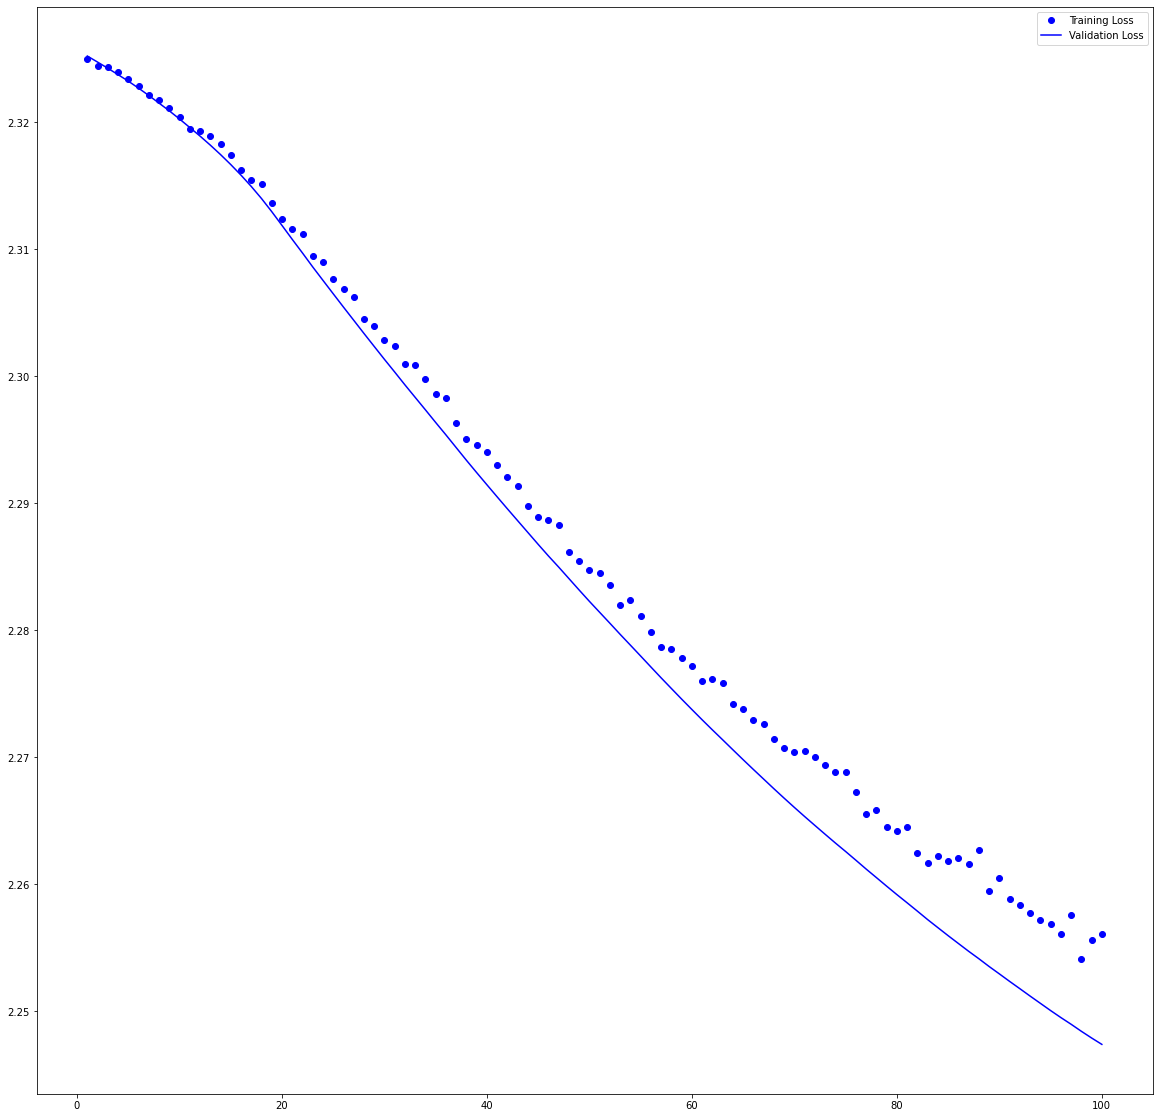

In [57]:
loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]
acc = training_history.history["acc"]
val_acc = training_history.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/loss_curves.png",dpi=400)

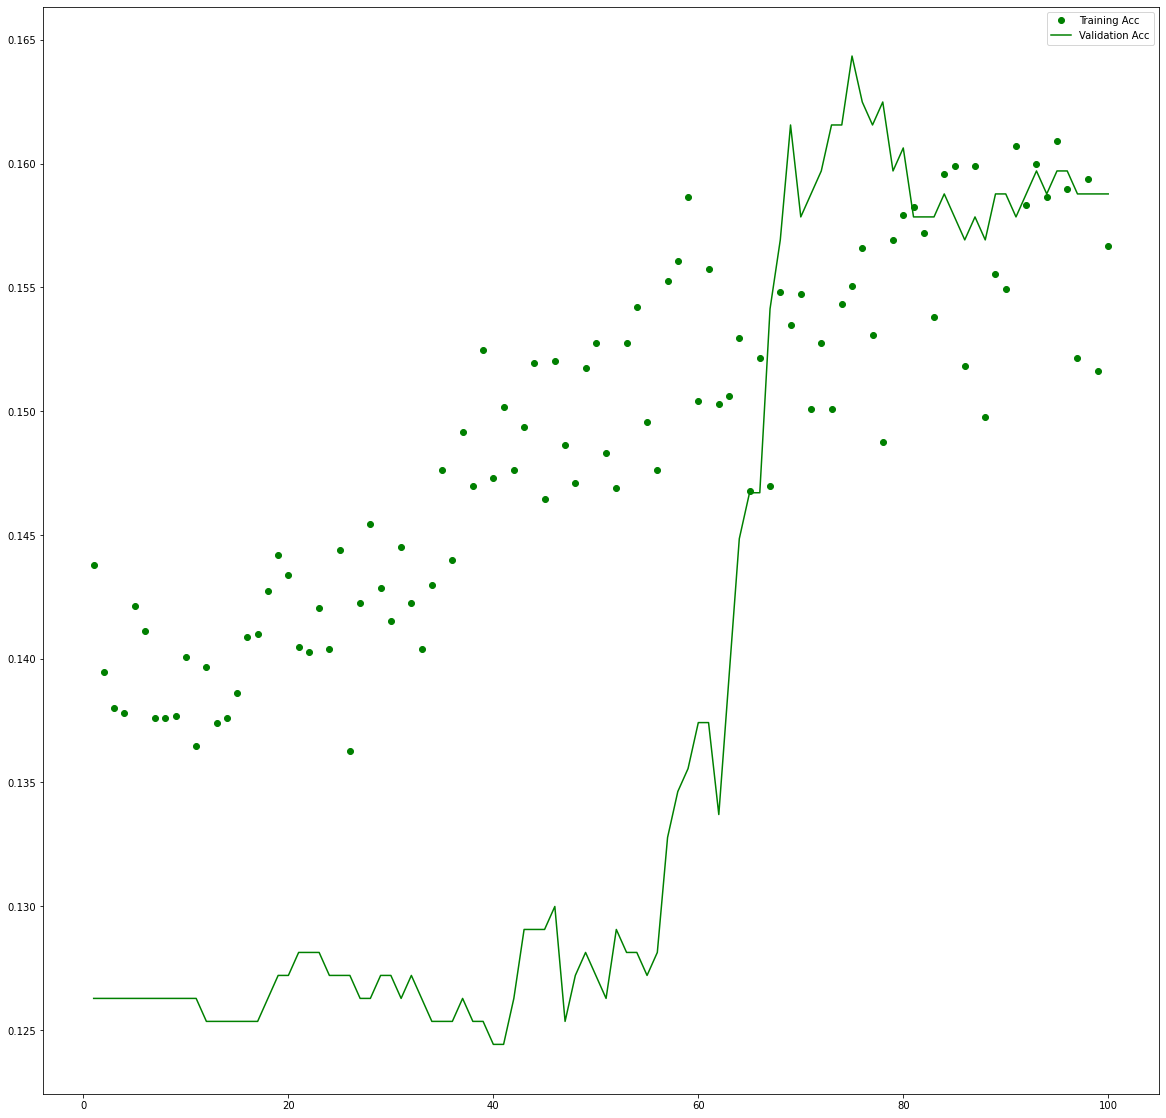

In [58]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/accuracy_curves.png",dpi=400)

Huge overfit!

Things I need to try:

* Collect more data
* Use a pretrained word embedding
* Regularize
* Add callbacks to make training work harder for me
* which should I use as a loss function: `sparse_categorical_crossentropy` or `categorical_crossentropy`
* Which optimizer should I use: `adam` or `RMSprop(lr=0.1)`

**TODO**:
Find out what it means when val_loss improves by val_acc does not improve.


## Test Example

In [48]:
score, acc = baseline_model.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

13/13 [==============================] - 0s 9ms/step - loss: 2.2579 - acc: 0.1554


In [49]:
print(score)

2.2579164505004883


In [50]:
print(acc)

0.1553884744644165


# Updated Model

# Conclusion